# Predict purchasing probability for financial product - Train model

### Introduction
-  Push calculations down to SAP HANA. 
-  Leverage the in-memory performance directly out of Python without data extraction.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Automated Predictive Library (APL):
   https://help.sap.com/viewer/cb31bd99d09747089754a0ba75067ed2/latest/en-US/5db34eae84ed44e49ec1f0f78dfb52a1.html
-  Dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing

### Automated Predictive Library

The Automated Predictive Library scales the use of Machine Learning through automation. Whilst the framework is highly automated, the inner workings are documented for the interested reader in the followng blog, which will also help with the model interpretation:
https://blogs.sap.com/2015/07/01/how-does-automated-analytics-do-it-the-magic-behind-creating-predictive-models-automatically/

### Create a HANA DataFrame, which points to the training data that remains in SAP HANA

In [1]:
# Obtain logon details from the central Connection Management of SAP Data Intelligence
import hana_ml.dataframe as dataframe

# Instantiate connection object
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId='HANADB')

# Create the HANA dataframe in the structure of the specified table
df_pushdown = conn.table("BANKMARKETING", schema="TAXX")

### Train Classification model with Automated Predictive Library (APL)

In [2]:
from hana_ml.algorithms.apl.classification import AutoClassifier
apl_model = AutoClassifier(conn_context=conn)

Specify the target column.

In [3]:
col_target = 'Y'

Specify the predictor columns.

In [4]:
col_predictors = df_pushdown.columns
col_predictors.remove('Y');
col_predictors.remove('CLIENT_ID');
col_predictors

['AGE',
 'JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'BALANCE',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'DAY',
 'MONTH',
 'POUTCOME']

Set further configurations and train the model

In [5]:
apl_model.set_params(target_key='yes') # The behaviour the model will predict
apl_model.set_params(cutting_strategy='random with test at end') # Internal splitting strategy
apl_model.fit(df_pushdown, label=col_target, key='CLIENT_ID', features=col_predictors)

### Model Quality

In [6]:
import pandas as pd
list_performance = apl_model.get_performance_metrics()
df_performance = pd.DataFrame(list(list_performance.items()), columns=["METRIC", "VALUE"])
df_performance.loc[df_performance['METRIC'].isin(['AUC','PredictivePower','PredictionConfidence'])]

,METRIC,VALUE
18,PredictivePower,0.4180
19,PredictionConfidence,0.9849
21,AUC,0.7160


### Model summary

In [7]:
apl_model.get_summary().collect()

,OID,KEY,VALUE
0,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelState,TrainedModel
1,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelDatasetName,APL_InputTrainingData
2,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelVariableCount,14
3,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelSelectedVariableCount,12
4,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelAvailable,true
5,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelRecordCount,45211
6,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelCuttingStrategy,random with test at end
7,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelRecordCountEstimation,26914
8,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelRecordCountValidation,9254
9,361D80A8_CEB3_46A0_B304_5C3C0EF951A2_0,ModelRecordCountTest,9043


### Variable Contributions

In [8]:
list_contributions = apl_model.get_feature_importances()
df_contribution = pd.DataFrame(list(list_contributions.items()), columns=["VARIABLE", "CONTRIBUTION"])
df_contribution = df_contribution.sort_values(by=['CONTRIBUTION'], ascending = False)
df_contribution

,VARIABLE,CONTRIBUTION
0,MONTH,0.272467
1,CONTACT,0.164968
2,BALANCE,0.102779
3,DAY,0.086136
4,AGE,0.083152
5,HOUSING,0.079452
6,JOB,0.078661
7,MARITAL,0.069132
8,LOAN,0.055573
9,EDUCATION,0.007680


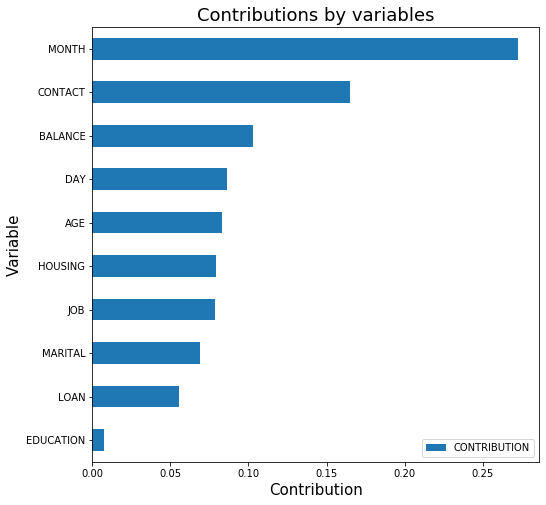

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
ax = df_contribution.plot.barh(figsize=(8, 8), x='VARIABLE', y="CONTRIBUTION");
#ax = df_contribution.plot.bar(x='VARIABLE', y="CONTRIBUTION", );
ax.set_title("Contributions by variables", fontsize=18)
ax.invert_yaxis();
ax.set_xlabel("Contribution", fontsize=15)
ax.set_ylabel("Variable", fontsize=15);

### Category Significance
Investigate how the information held in a column affects the prediction.

In [10]:
variable_name = "MONTH"

# Obtain the Group Normal Profit, the Group Target Mean and the Group Frequency
df_indicators = apl_model.get_indicators().collect()
df_group_profit = df_indicators[(df_indicators['KEY']=='GroupNormalProfit') & (df_indicators['VARIABLE']==variable_name)].copy()
df_group_target_mean = df_indicators[(df_indicators['KEY']=='GroupTargetMean') & (df_indicators['VARIABLE']==variable_name)].copy()
df_group_frequency = df_indicators[(df_indicators['KEY']=='GroupFrequency') & (df_indicators['VARIABLE']==variable_name)].copy()

# Turn the value variable into a float
df_group_profit["VALUE"] = df_group_profit["VALUE"].astype(float)
df_group_target_mean["VALUE"] = df_group_target_mean["VALUE"].astype(float)
df_group_frequency["VALUE"] = df_group_frequency["VALUE"].astype(float)

# Rename the value variable
df_group_profit.rename(columns={'VALUE': 'GROUP_PROFIT'}, inplace=True)
df_group_target_mean.rename(columns={'VALUE': 'GROUP_TARGET_MEAN'}, inplace=True)
df_group_frequency.rename(columns={'VALUE': 'GROUP_FREQUENCY'}, inplace=True)

# Drop unnecessary columns
df_group_frequency = df_group_frequency[["DETAIL", "GROUP_FREQUENCY"]]

# Join the data frames
df_category_signif = pd.merge(df_group_profit, df_group_target_mean, on='DETAIL')
df_category_signif = pd.merge(df_category_signif, df_group_frequency, on='DETAIL')

# Group order
group_order = df_category_signif.sort_values("GROUP_TARGET_MEAN", ascending=False)["DETAIL"]

# Rename
df_category_signif.rename(columns={'DETAIL': 'CATEGORIES'}, inplace=True)

# influence on target
z_approx = 0.25 # see https://help.sap.com/viewer/bc031e667eea409c9e08e7ab8b1e4c70/3.3/en-US/4658fb102e9b4d9399d6dcb644dfab4c.html
df_category_signif["INFLUENCE"] = df_category_signif["GROUP_PROFIT"] * df_category_signif["GROUP_FREQUENCY"] / z_approx

In the following bar chart, categories on the left hand side have the highest proportion of the target population. The categories are sorted in descending order of the proportion. When the influence (y-axis) becomes negative, the target proportion of the category is lower than the overall's population. The  further left the category, the higher the affinity.

In [14]:
#!pip install seaborn

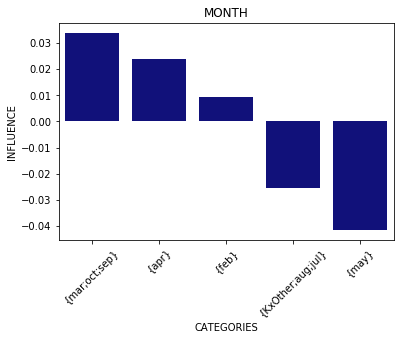

In [15]:
import seaborn as sns
bplot = sns.barplot(x="CATEGORIES", y="INFLUENCE", order=group_order, color="darkblue", data=df_category_signif)
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45);

### Save the model to SAP HANA table

In [16]:
apl_model.save_model(schema_name='TAXX', table_name='BANKMARKETING_MODEL_APL',if_exists='replace')

### Close connection

In [ ]:
conn.close()